In [4]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
import matplotlib as mpl
from scipy.stats import ttest_rel
import utils
from utils import loading, scoring
from gerkin import dream,params,fit2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load and organize the features and descriptor data

In [5]:
# Load the data
descriptors = loading.get_descriptors(format=True)
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
#mdx_full = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
mdx_drag_morg = dream.get_molecular_data(['dragon','morgan'],all_CIDs)
mdx_drag = dream.get_molecular_data(['dragon'],all_CIDs)

Morgan has 2437 features for 476 molecules.
There are now 7307 total features.
There are now 4870 total features.


In [6]:
# Create the feature and descriptor arrays
sets = ['training','leaderboard']
X_drag,good1,good2,means,stds,imputer = dream.make_X(mdx_drag,sets)
X_drag_morg,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,sets)
X_drag_sq = dream.quad_prep(mdx_drag,sets=sets)
X_drag_morg_sq = dream.quad_prep(mdx_drag_morg,sets=sets)
Y_all,imputer = dream.make_Y_obs(sets,target_dilution=None,imputer='mask')

The X matrix now has shape (814x3063) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x9740) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x14614) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


## Compute or load correlations for the linear model

### Load or compute feature ranks for the linear model

In [43]:
n_splits = 100
use_saved_linear_feature_ranks = True
if use_saved_linear_feature_ranks:
    lin_ranked_drag_morg = np.load('../../data/lin_ranked_rick.npy')
else:
    lin_ranked_drag_morg = fit2.compute_linear_feature_ranks_cv(X_drag_morg_sq[:,:-1],Y_all['mean_std'],
                                                                n_resampling=10,n_splits=n_splits)
    np.save('../../data/lin_ranked_rick',lin_ranked_drag_morg)

In [44]:
use_saved_linear_feature_ranks = True
if use_saved_linear_feature_ranks:
    lin_ranked_drag = np.load('../../data/lin_ranked_rick_drag.npy')
else:
    lin_ranked_drag = fit2.compute_linear_feature_ranks_cv(X_drag_sq[:,:-1],Y_all['mean_std'],
                                                                n_resampling=10,n_splits=n_splits)
    np.save('../../data/lin_ranked_rick_drag',lin_ranked_drag)

Computing feature ranks for descriptor #0, split #0
Computing feature ranks for descriptor #0, split #1
Computing feature ranks for descriptor #0, split #2
Computing feature ranks for descriptor #0, split #3
Computing feature ranks for descriptor #0, split #4
Computing feature ranks for descriptor #0, split #5
Computing feature ranks for descriptor #0, split #6
Computing feature ranks for descriptor #0, split #7
Computing feature ranks for descriptor #0, split #8
Computing feature ranks for descriptor #0, split #9
Computing feature ranks for descriptor #0, split #10
Computing feature ranks for descriptor #0, split #11
Computing feature ranks for descriptor #0, split #12
Computing feature ranks for descriptor #0, split #13
Computing feature ranks for descriptor #0, split #14
Computing feature ranks for descriptor #0, split #15
Computing feature ranks for descriptor #0, split #16
Computing feature ranks for descriptor #0, split #17
Computing feature ranks for descriptor #0, split #18
Com

In [48]:
use_saved_linear_model = True
max_features = 1000
alpha = 10.0
if use_saved_linear_model:
    rs_lin_with_morgan = np.load('../../data/rs_lin_with_morgan.npy')
else:
    rs_lin_with_morgan = fit2.master_cv(X_drag_morg_sq[:,:-1],Y_all['mean_std'],n_splits=n_splits,model='ridge',
                                        alpha=alpha,feature_list=lin_ranked_drag_morg[:,:,:max_features])
    np.save('../../data/rs_lin_with_morgan',rs_lin_with_morgan)

0
Desc. 0: 0.648
1
Desc. 1: 0.581
2
Desc. 2: 0.476
3
Desc. 3: 0.617
4
Desc. 4: 0.654
5
Desc. 5: 0.525
6
Desc. 6: 0.598
7
Desc. 7: 0.423
8
Desc. 8: 0.401
9
Desc. 9: 0.453
10
Desc. 10: 0.513
11
Desc. 11: 0.399
12
Desc. 12: 0.282
13
Desc. 13: 0.473
14
Desc. 14: 0.457
15
Desc. 15: 0.358
16
Desc. 16: 0.514
17
Desc. 17: 0.407
18
Desc. 18: 0.405
19
Desc. 19: 0.536
20
Desc. 20: 0.553


In [45]:
use_saved_linear_model = True
if use_saved_linear_model:
    rs_lin_without_morgan = np.load('../../data/rs_lin_without_morgan.npy')
else:
    rs_lin_without_morgan = fit2.master_cv(X_drag_sq[:,:-1],Y_all['mean_std'],n_splits=n_splits,model='ridge',
                                        alpha=alpha,feature_list=lin_ranked_drag[:,:,:max_features])
    np.save('../../data/rs_lin_without_morgan',rs_lin_without_morgan)

0
Desc. 0: 0.599
1
Desc. 1: 0.534
2
Desc. 2: 0.407
3
Desc. 3: 0.531
4
Desc. 4: 0.596
5
Desc. 5: 0.487
6
Desc. 6: 0.596
7
Desc. 7: 0.419
8
Desc. 8: 0.391
9
Desc. 9: 0.431
10
Desc. 10: 0.509
11
Desc. 11: 0.355
12
Desc. 12: 0.228
13
Desc. 13: 0.445
14
Desc. 14: 0.417
15
Desc. 15: 0.315
16
Desc. 16: 0.474
17
Desc. 17: 0.352
18
Desc. 18: 0.323
19
Desc. 19: 0.524
20
Desc. 20: 0.516


## Compute or load correlations for the random forest model

In [22]:
use_saved_rf_model = True
if use_saved_rf_model:
    rs_dec_with_morgan = np.load('../../data/rs_dec_with_morgan.npy')
else:
    rs_dec_with_morgan = fit2.master_cv(X_drag_morg[:,:-1],Y,n_estimators=50,n_splits=n_splits,model='rf')
    np.save('../../data/rs_dec_with_morgan',rs_dec_with_morgan)

In [23]:
use_saved_rf_model = True
if use_saved_rf_model:
    rs_dec_without_morgan = np.load('../../data/rs_dec_without_morgan.npy')
else:
    rs_dec_without_morgan = fit2.master_cv(X_drag[:,:-1],Y,n_estimators=50,n_splits=n_splits,model='rf')
    np.save('../../data/rs_dec_without_morgan',rs_dec_without_morgan)

## Fig. 5A

In [50]:
n_splits = 50
# Compute differences between with and without Morgan.  
wit = [rs_dec_with_morgan[:,:n_splits],rs_lin_with_morgan[:,:n_splits]]
wout = [rs_dec_without_morgan[:,:n_splits],rs_lin_without_morgan[:,:n_splits]]
diff = [wit[i].mean(axis=1) - wout[i].mean(axis=1) for i in range(2)]
order = [np.argsort(diff[i])[::-1] for i in range(2)]
order[1] = order[0]
ts,ps = [np.zeros(21),np.zeros(21)],[np.zeros(21),np.zeros(21)]

# Compute p-values and sort by effect size
for i in range(2):
    for j in range(21):
        ts[i][j],ps[i][j] = ttest_rel(wit[i][j,:],wout[i][j,:])
        ps[i][j] = ps[i][j]*21/(np.argsort(ps[i][j])+1) # FDR correction
    ts[i] = ts[i][order[i]]
    ps[i] = ps[i][order[i]]
    diff[i] = diff[i][order[i]]
    wit[i] = wit[i][order[i],:]
    wout[i] = wout[i][order[i],:]   
    
# Compute error bars
yerr = [(wit[i] - wout[i]).std(axis=1)/np.sqrt(n_splits) for i in range(2)]
yerr1 = [[yerr[i][j] if diff[i][j]>=0 else np.nan for j in range(21)] for i in range(2)]
yerr2 = [[yerr[i][j] if diff[i][j]<0 else np.nan for j in range(21)] for i in range(2)]

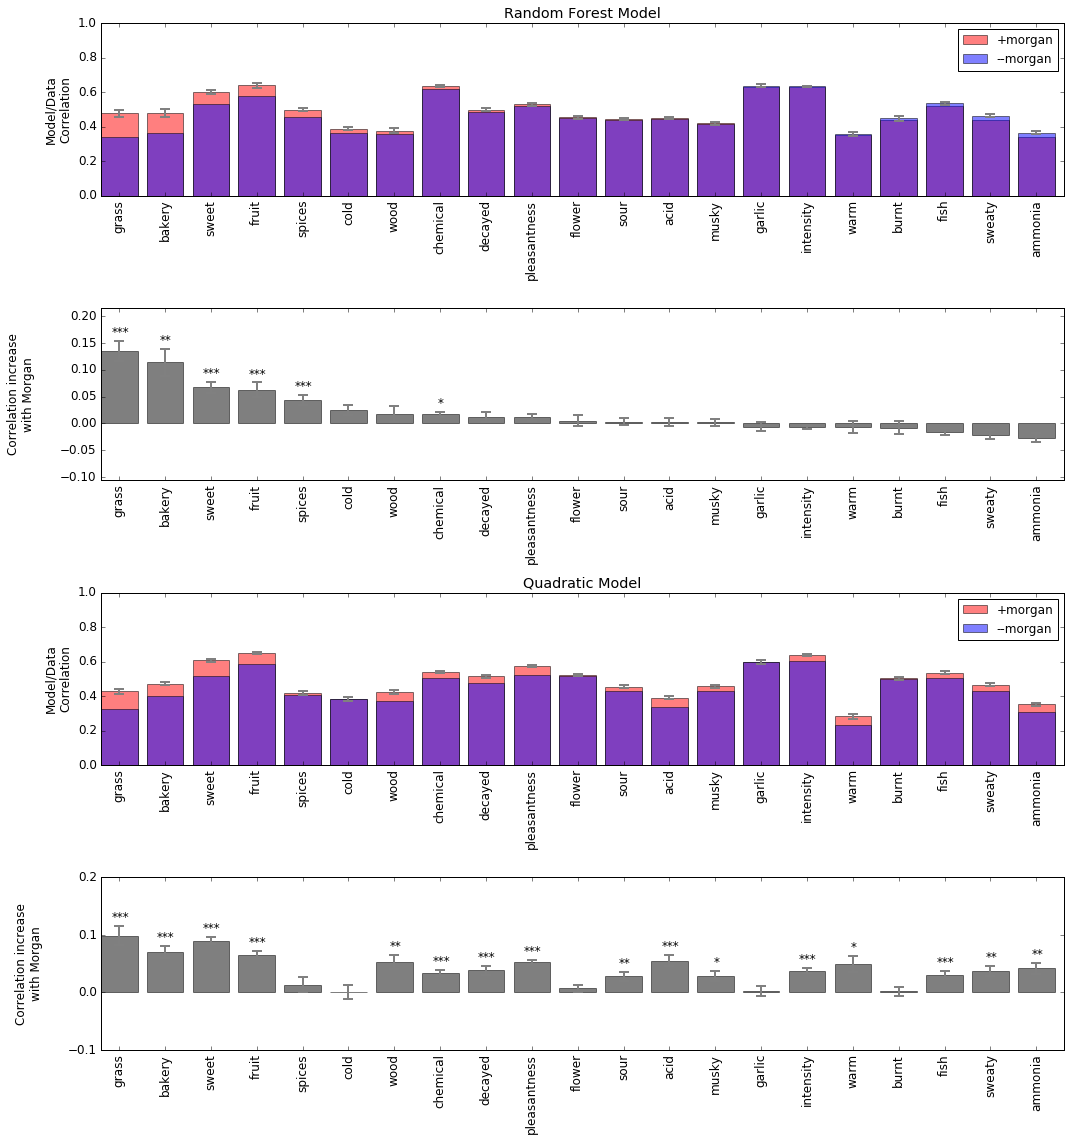

In [51]:
# Plot the correlations, with and without the Morgan features.  
mpl.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(4,1,figsize=(15,16),sharex=False)

for i in range(2):
    ax[2*i].bar(np.arange(21),wit[i].mean(axis=1),color='r',yerr=yerr1[i],
          error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),alpha=0.5,label='+morgan')
    ax[2*i].bar(np.arange(21),wout[i].mean(axis=1),color='b',yerr=yerr2[i],
          error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),alpha=0.5,label='--morgan')
    ax[2*i+1].bar(np.arange(21),
              diff[i],
              yerr=yerr[i],color='k',#width=0.4,
              error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2),
              alpha=0.5)
    for j in range(21):
        if ps[i][j] < 0.001:
            star = '***'
        elif ps[i][j] < 0.01:
            star = '**'
        elif ps[i][j] < 0.05:
            star = '*'
        else:
            star = ''
        ax[2*i+1].text(j+0.42,diff[i][j]+(-1 if diff[i][j]<0 else 1)*(yerr[i][j]+0.015),star,
                       size=12,horizontalalignment='center',verticalalignment='center')
    ax[2*i].legend(fontsize=12)
    ax[2*i].set_ylim(0,1)
    ax[2*i+1].set_ylim(diff[i].min()-0.08,diff[i].max()+0.08)
    ax[2*i].set_ylabel('Model/Data\nCorrelation')
    ax[2*i+1].set_ylabel('Correlation increase\nwith Morgan')
    ax[2*i+1].yaxis.labelpad = 25
    ax[2*1+1].set_yticks(np.arange(-0.1,0.3,0.1))

for i in range(4):
    ax[i].set_xlim(0,21)
    ax[i].set_xticks(np.arange(21)+0.4)
    ax[i].set_xticklabels([_.split('/')[0].lower() for _ in [descriptors[j] for j in order[int(i/2)]]],rotation=90)
ax[0].set_title('Random Forest Model')
ax[2].set_title('Quadratic Model')
plt.tight_layout()

plt.savefig('../../figures/with_without_morgan.eps',format='eps')